In [65]:
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, FunctionTransformer




# Data Cleaning

In [50]:
# Read Data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Feature Engineering, Compute Missing Age Data
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

train['Cabin'] = train['Cabin'].fillna('none')
test['Cabin'] = test['Cabin'].fillna('none')

test['Fare'] = test['Fare'].fillna(test['Fare'].median())

train['Has_Cabin'] = train['Cabin'] != 'none'
test['Has_Cabin'] = test['Cabin'] != 'none'

train['Title'] = train['Name'].str.extract(r',\s*([^\.]+)\.')
train['Title'] = np.where(
    train['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master']),
    train['Title'],
    'Other'
)

test['Title'] = test['Name'].str.extract(r',\s*([^\.]+)\.')
test['Title'] = np.where(
    test['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master']),
    test['Title'],
    'Other'
)

# Label Numeric and Categorical Variables
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Title', 'Embarked', 'Has_Cabin']

# Missing Age Analysis

In [51]:
missing_age = train[train['Age'].isna()]
has_age = train[~train['Age'].isna()]

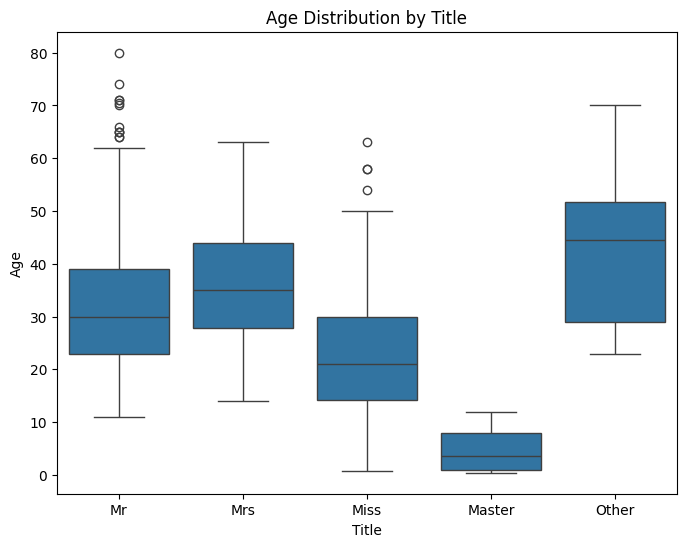

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(x='Title', y='Age', data=train)
plt.title('Age Distribution by Title')
plt.ylabel('Age')
plt.xlabel('Title')
plt.show()

In [53]:
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

# ANOVA test for Age differences across Title groups

groups = [train[train['Title'] == title]['Age'].values for title in train['Title'].unique()]
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print("\nMean Age by Title:")
print(train.groupby('Title')['Age'].mean().round(2))

# Post-hoc pairwise comparisons using t-tests
print("\nPairwise t-tests between Title groups:")
titles = train['Title'].unique()
for i in range(len(titles)):
    for j in range(i+1, len(titles)):
        group1 = train[train['Title'] == titles[i]]['Age'].values
        group2 = train[train['Title'] == titles[j]]['Age'].values
        t_stat, p_val = ttest_ind(group1, group2)
        print(f"{titles[i]} vs {titles[j]}: t-statistic = {t_stat:.3f}, p-value = {p_val:.6f}")

F-statistic: nan
P-value: nan

Mean Age by Title:
Title
Master     4.57
Miss      21.77
Mr        32.37
Mrs       35.90
Other     42.38
Name: Age, dtype: float64

Pairwise t-tests between Title groups:
Mr vs Mrs: t-statistic = nan, p-value = nan
Mr vs Miss: t-statistic = nan, p-value = nan
Mr vs Master: t-statistic = nan, p-value = nan
Mr vs Other: t-statistic = nan, p-value = nan
Mrs vs Miss: t-statistic = nan, p-value = nan
Mrs vs Master: t-statistic = nan, p-value = nan
Mrs vs Other: t-statistic = nan, p-value = nan
Miss vs Master: t-statistic = nan, p-value = nan
Miss vs Other: t-statistic = nan, p-value = nan
Master vs Other: t-statistic = nan, p-value = nan


In [54]:
train['Age'] = train.groupby('Title')['Age'].transform(
    lambda x: x.fillna(x.median())
)

test['Age'] = test.groupby('Title')['Age'].transform(
    lambda x: x.fillna(x.median())
)

In [55]:
X_train = train[numeric_features + categorical_features]
y_train = train['Survived']

X_test = test[numeric_features + categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Exploratory Data Analysis

In [56]:
X_train[numeric_features].corr()

,Age,SibSp,Parch,Fare
Age,1.000000,-0.265577,-0.188081,0.097939
SibSp,-0.265577,1.000000,0.414838,0.159651
Parch,-0.188081,0.414838,1.000000,0.216225
Fare,0.097939,0.159651,0.216225,1.000000


In [57]:
total_males = (train['Sex'] == 'male').sum()
total_females = (train['Sex'] == 'female').sum()

total_male_survivors = ((train['Sex'] == 'male') & (train['Survived'] == 1)).sum()
total_female_survivors = ((train['Sex'] == 'female') & (train['Survived'] == 1)).sum()

count = [total_male_survivors, total_female_survivors]
n_obs = [total_males, total_females]

stat, p_value = proportions_ztest(count, n_obs)
print(f"Male Survivor % : {(total_male_survivors / total_males) * 100:.3f}")
print(f"Female Survivor % : {(total_female_survivors / total_females) * 100:.3f}")

print(f"Z-statistic: {stat:.3f}, p-value: {p_value:.3f}")

Male Survivor % : 18.891
Female Survivor % : 74.204
Z-statistic: -16.219, p-value: 0.000


In [58]:
total_has_cabin = (train['Has_Cabin']).sum()
total_no_cabin = (~train['Has_Cabin']).sum()

total_has_cabin_survivors = ((train['Has_Cabin']) & (train['Survived'] == 1)).sum()
total_no_cabin_survivors = ((~train['Has_Cabin']) & (train['Survived'] == 1)).sum()

n_obs = [total_has_cabin, total_no_cabin]
count = [total_has_cabin_survivors, total_no_cabin_survivors]

stat, p_value = proportions_ztest(count, n_obs)
print(f"Cabin Survivor % : {(total_has_cabin_survivors / total_has_cabin) * 100:.3f}")
print(f"No Cabin Survivor % : {(total_no_cabin_survivors / total_no_cabin) * 100:.3f}")

print(f"Z-statistic: {stat:.3f}, p-value: {p_value:.3f}")


Cabin Survivor % : 66.667
No Cabin Survivor % : 29.985
Z-statistic: 9.460, p-value: 0.000


In [59]:
cont_table = pd.crosstab(train['Pclass'], train['Survived'])
print(cont_table)

chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119
Chi2 statistic: 102.889
P-value: 0.000


In [60]:
cont_table = pd.crosstab(train['Embarked'], train['Survived'])
print(cont_table)

chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219
Chi2 statistic: 25.964
P-value: 0.000


In [61]:
cont_table = pd.crosstab(train['Title'], train['Survived'])
print(cont_table)

chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")

# Display survival percentages by title
print("\nSurvival Rate by Title:")
survival_rate = cont_table[1] / cont_table.sum(axis=1) * 100
print(survival_rate.round(2))

Survived    0    1
Title             
Master     17   23
Miss       55  127
Mr        436   81
Mrs        26   99
Other      15   12
Chi2 statistic: 283.312
P-value: 0.000

Survival Rate by Title:
Title
Master    57.50
Miss      69.78
Mr        15.67
Mrs       79.20
Other     44.44
dtype: float64


In [62]:
model = LinearSVC(max_iter=10000, random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [69]:
# Cross Validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(max_iter=10000, tol=1e-5))
])

param_grid = {
    'svc__C' : np.arange(0.00001, 0.01, 0.00001),
    'svc__loss' : ['hinge', 'squared_hinge']
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(pipeline, param_grid, cv = skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_


Best parameters: {'svc__C': np.float64(0.00506), 'svc__loss': 'squared_hinge'}
Best cross-validation score: 0.829


In [ ]:
X_vif = add_constant(X_train_scaled)
vif_data = pd.DataFrame()
feature_names = ['const'] + list(preprocessor.get_feature_names_out())
vif_data['feature'] = feature_names
vif_data['VIF'] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

print(vif_data)

In [64]:
submission = pd.DataFrame({
    "PassengerId" : test['PassengerId'],
    "Survived" : best_model.predict(X_test_scaled)
})

submission.to_csv("data/submission.csv", index = False)